# 1. Import Libraries

Importing libraries is essential to prepare functions and tools
for data manipulation (pandas, numpy), visualization (matplotlib, seaborn),
statistical operations (statsmodels, scipy), machine learning (sklearn),
and evaluation metrics.

Accurate imports ensure reproducibility and usage of appropriate algorithms
and tests customized for anomaly detection contexts.

## 1.1 Common Libraries

In [3]:
import pandas as pd                   # Data manipulation & analysis
import numpy as np                    # Numerical computations
import os                             # File and operating system utilities
import matplotlib.pyplot as plt       # Visualization
import seaborn as sns                 # Statistical data visualization
import math                           # Built-in mathematical functions

## 1.2 Statistical Methods

In [8]:
from statsmodels.stats.proportion import proportion_confint # Confidence intervals for proportions (e.g., Wilson’s CI)
from sklearn.utils.class_weight import compute_class_weight # Handle class imbalance
from scipy.stats import zscore                              # Z-score (standard score calculation)
from pyod.models.mad import MAD                             # Median Absolute Deviation (robust anomaly detection)

## 1.3 Data Splitting

In [9]:
from sklearn.model_selection import train_test_split # Split data into training and testing sets

## 1.4 Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler              # Feature scaling
from sklearn.preprocessing import OneHotEncoder               # Categorical encoding
from sklearn.compose import ColumnTransformer                 # Apply transformations to columns
from sklearn.pipeline import Pipeline                         # Create preprocessing + modeling pipelines
from sklearn.impute import SimpleImputer                      # Handle missing data
from sklearn.preprocessing import label_binarize              # Convert labels into binary indicators

## 1.5 Models

In [11]:
from sklearn.linear_model import LogisticRegression           # Supervised learning: Logistic Regression Classifier
from sklearn.ensemble import RandomForestClassifier           # Supervised learning: Random Forest Classifier

## 1.6 Evaluation Metrics

In [12]:
from sklearn.metrics import classification_report             # Detailed classification metrics
from sklearn.metrics import roc_auc_score                     # Area Under ROC curve
from sklearn.metrics import confusion_matrix                  # Compute confusion matrix
from sklearn.metrics import balanced_accuracy_score           # Balanced accuracy (for imbalanced data)
from sklearn.metrics import precision_score                   # Precision
from sklearn.metrics import average_precision_score           # Average precision (useful for PR curve)
from sklearn.metrics import recall_score                      # Recall
from sklearn.metrics import f1_score                          # F1-score

# 2. Data Loading

Load the data into memory and parse dates.

Correct loading is foundational as downstream steps rely on proper data types and formats,
especially dates which can be used for temporal anomaly trend analysis.

Column structure inspection helps confirm dataset consistency against expectations.

In [14]:
path = "./data/warnings_vin_sample.csv"
df = pd.read_csv(path, sep=";")
df["reporting_date"] = pd.to_datetime(df["reporting_date"], errors="coerce")
print(df.columns)

Index(['layer_name', 'ctt_cms_contract_number', 'ctt_vin',
       'ctt_asset_type_segment', 'entity_name', 'reporting_date',
       'anomaly_description', 'anomaly_flag'],
      dtype='object')


# 3. Sanity Checks

Sanity checks validate dataset integrity before modeling.

- Shape and info ensure dataset loaded fully and data types are appropriate.
- Summary statistics give insight into distributions, ranges, and missing data patterns.
- Identification of constant columns prevents redundant features causing noise.
- Splitting categorical and numeric helps in later tailored preprocessing.
- High-cardinality features indicate need for special encoding (frequency or target encoding).
- Duplicate row check guards against data leakage or bias.
- Target distribution review ensures meaningful class representation for supervised learning.
- Sanity checks for specific columns like VIN confirm domain-specific expectations.

## 3.1 Basic shape and info

In [15]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

Shape: (5055, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   layer_name               5055 non-null   object        
 1   ctt_cms_contract_number  5055 non-null   object        
 2   ctt_vin                  3929 non-null   object        
 3   ctt_asset_type_segment   5055 non-null   object        
 4   entity_name              5055 non-null   object        
 5   reporting_date           5055 non-null   datetime64[ns]
 6   anomaly_description      5055 non-null   object        
 7   anomaly_flag             5055 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 316.1+ KB
None


## 3.2 Summary Statistics

5-Number Statistics: 
One of the quickest methods for getting a feel for new data is the 5-number summary. It prints out 5 metrics about a distribution - the minimum, 25th percentile, median, 75th percentile, and the maximum along with mean and standard deviation. By looking at the 5-number summary and the difference between the mean and the minimum/maximum values, you can get a rough idea of whether outliers are present in the distribution.


In [16]:
df["anomaly_flag"].describe()

count    5055.000000
mean        0.006726
std         0.081744
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: anomaly_flag, dtype: float64

## 3.3 Numeric and categorical split

* Checking high-cardinality categoricals
    * Categorical features are variables that can take on one of several set values (categories).
    * When the number of unique categories in such a feature is very large, it is called high cardinality.

* Why is checking high-cardinality categoricals important?
    * High-cardinality categorical features can cause problems in machine learning, such as:
        * Explosion in the number of features after encoding (e.g., one-hot encoding).
        * Increased storage and computation requirements.
        * Risk of model overfitting due to noise from many sparse categories.
        * Difficulty in encoding, as simple methods may not handle so many categories well.
    * Models may struggle because many categories may appear in either train or test sets but not both, causing inconsistencies.

In [17]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

### High-cardinality categoricals
high_card = [c for c in cat_cols if df[c].nunique() > 100]
print("\nHigh-cardinality categoricals:", high_card)


High-cardinality categoricals: ['ctt_cms_contract_number', 'ctt_vin', 'reporting_date']


## 3.4 Feature info summary

In [18]:
feature_info = pd.DataFrame({
    "dtype": df.dtypes,
    "n_missing": df.isna().sum(),
    "% missing": (df.isna().sum() / len(df) * 100).round(2),
    "n_unique": df.nunique(),
})
print("\nFeature Information:")
print(feature_info)


Feature Information:
                                  dtype  n_missing  % missing  n_unique
layer_name                       object          0       0.00         2
ctt_cms_contract_number          object          0       0.00      4680
ctt_vin                          object       1126      22.27      3563
ctt_asset_type_segment           object          0       0.00         5
entity_name                      object          0       0.00         1
reporting_date           datetime64[ns]          0       0.00       136
anomaly_description              object          0       0.00         2
anomaly_flag                      int64          0       0.00         2


## 3.5 Duplicates at dataset level

In [19]:
n_dupes = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {n_dupes}")


Number of duplicate rows: 59


## 3.6 Target distribution (detailed anomaly_description)

In [20]:
print("\nAnomaly description distribution:")
for i, (k, v) in enumerate(df["anomaly_description"].value_counts().items()):
    print(f"{i}. {k}: {v}")


Anomaly description distribution:
0. No anomaly detected for VIN: 5021
1. Warning Prio 2/No matches found within the Mapis table lookup for the VIN: 34


## 3.7 VIN sanity check

In [21]:
df_vin_contradict = df[
    df["ctt_vin"].isna() & 
    (df["anomaly_description"].str.contains("No anomaly detected", na=False))
]
print(f"\nRecords with missing VIN but 'No anomaly detected': {len(df_vin_contradict)}")


Records with missing VIN but 'No anomaly detected': 1126


## 3.8 Data Visualizations

### 3.8.1 Histograms for Outlier detection

* A histogram can be a compelling visual for finding outliers.
* They can become apparent when an appropriate number of bins is chosen for the histogram.
* Recall that the square root of the number of observations can be used as a rule of thumb for setting the number of bins. But we can ignore this as this is a binary classification detection problem.
* Usually, the bins with the lowest heights will contain outliers.

In [22]:
binary_flag = df["anomaly_flag"]

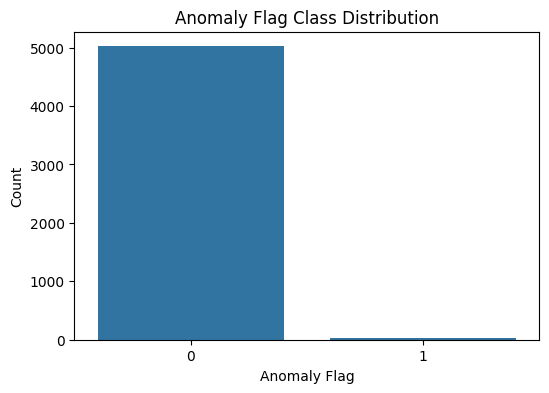

In [40]:
#### Bar chart showing anomaly_flag balance
plt.figure(figsize=(6, 4))
sns.countplot(x='anomaly_flag', data=df)
plt.title('Anomaly Flag Class Distribution')
plt.xlabel('Anomaly Flag')
plt.ylabel('Count')
plt.show()

# 4. Class Distribution Analysis

Analysis of class balance is critical in anomaly detection characterized by rare positive samples.

- Class imbalance affects model training and evaluation.
- Prevalence and confidence intervals are statistical measures helping assess data sufficiency and reliability.
- Wilson's method for confidence intervals is robust for binomial proportions often used for anomaly labels.
- Standard error quantifies uncertainty aiding considered thresholding and risk assessment.

## 4.1 Class imbalance

In [35]:
class_counts = df["anomaly_flag"].value_counts()
n0, n1 = class_counts[0], class_counts[1]

print("Majority class (0):", n0)
print("Minority class (1):", n1)
print("Class imbalance present? ->", n0 != n1)

Majority class (0): 5021
Minority class (1): 34
Class imbalance present? -> True


## 4.2 Class Imbalance Ratio (CIR)

In [36]:
target = "anomaly_flag"
n0, n1 = df[target].value_counts().values
cir = max(n0, n1) / min(n0, n1)
print(f"Class imbalance ratio: {cir:.2f}:1")

Class imbalance ratio: 147.68:1


## 4.3 Prevalence

In [37]:
n_total = len(df)
n_pos = n1
prevalence = n_pos / n_total
print(f"Prevalence of anomalies: {prevalence:.5f} ({100*prevalence:.3f}%)")

Prevalence of anomalies: 0.00673 (0.673%)


## 4.4 Wilsons 95% CI

In [38]:
ci_low, ci_high = proportion_confint(count=n_pos, nobs=n_total, method="wilson")
print(f"Wilson 95% CI for prevalence: [{ci_low:.5f}, {ci_high:.5f}]")

Wilson 95% CI for prevalence: [0.00482, 0.00938]


## 4.5 Standard Error

In [39]:
SE = (prevalence * (1 - prevalence) / n_total) ** 0.5
print(f"Standard Error of prevalence: {SE:.6f}")

Standard Error of prevalence: 0.001150


# 5. Data Sufficiency

Calculate sample size and required positive/negative cases to achieve a margin of error at specified confidence levels.

Ensures dataset size and class proportions provide statistically significant model training
and avoid misleading results from insufficient data.

In [41]:
def required_n_for_proportion(m=0.05, confidence=0.95, p=None):
    from scipy.stats import norm
    z = norm.ppf(1 - (1 - confidence) / 2)
    
    # Worst-case prevalence if not provided
    if p is None:
        p = 0.5
    
    n_needed = math.ceil((z**2) * p * (1 - p) / (m**2))
    return n_needed

In [42]:
## Apply to your dataset
## 95% CI, ±5% margin of error
n_needed = required_n_for_proportion(m=0.05, confidence=0.95)

## Expected prevalence from data
p_hat = df["anomaly_flag"].mean()

## Adjusted required positives (if prevalence is low)
n_pos_needed = math.ceil(n_needed * p_hat)
n_neg_needed = n_needed - n_pos_needed

print(f"Required total sample size: {n_needed}")
print(f"Given prevalence={p_hat:.5f}:")
print(f"Required positives: {n_pos_needed}")
print(f"Required negatives: {n_neg_needed}")

Required total sample size: 385
Given prevalence=0.00673:
Required positives: 3
Required negatives: 382


# 6. Feature Selection

Select relevant features while preventing data leakage and redundancy.

- Drop constant, leakage-prone columns (e.g. anomaly_description heavily correlated with label).
- Preserve domain-important identifiers (ctt_vin, ctt_cms_contract_number).
- Remove highly correlated numeric features to reduce multicollinearity.
- This process improves model generalization and interpretability.

## 6.1 Correlation with target (numeric only)

In [43]:
cor_target = df.corr(numeric_only=True)["anomaly_flag"].abs().sort_values(ascending=False)
print("Correlation with target:\n", cor_target)

Correlation with target:
 anomaly_flag    1.0
Name: anomaly_flag, dtype: float64


## 6.2 Candidate columns to drop

In [44]:
### Identify columns to drop based on criteria
drop_cols = []

cols = df.columns

### Drop columns with single unique value (constant)
for col in cols:
    if df[col].nunique() == 1:
        drop_cols.append(col)

### Drop columns likely causing data leakage or not useful
leakage_candidates = ['anomaly_description']  # Text describing target, high leakage risk
drop_cols += [col for col in leakage_candidates if col in cols]

### Final drop columns ensuring to keep important ID columns
ids_to_keep = ['ctt_cms_contract_number', 'ctt_vin']
drop_cols = [col for col in drop_cols if col not in ids_to_keep]

print(f"Columns to drop based on logic: {drop_cols}")

Columns to drop based on logic: ['entity_name', 'anomaly_description']


## 6.3 Remove identified columns

In [45]:
df_model = df.drop(columns=list(drop_cols))
print(df_model.columns)

Index(['layer_name', 'ctt_cms_contract_number', 'ctt_vin',
       'ctt_asset_type_segment', 'reporting_date', 'anomaly_flag'],
      dtype='object')


## 6.4 Remove highly correlated numeric features (multicollinearity check)

In [46]:
### Create correlation matrix for features only (exclude target)
### Select only numeric columns for correlation matrix
numeric_feats = df_model.select_dtypes(include=[np.number]).columns.tolist()

### Exclude target column if present
if "anomaly_flag" in numeric_feats:
    numeric_feats.remove("anomaly_flag")

### Now compute correlation matrix only on numeric features
corr_matrix = df_model[numeric_feats].corr().abs()

### Upper triangle mask to avoid duplicated pairs and diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

### Identify highly correlated columns
high_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Highly correlated numeric features (r > 0.95) to drop:", high_corr)

Highly correlated numeric features (r > 0.95) to drop: []


## 6.5 Final

In [47]:
df_model = df_model.drop(columns=high_corr)
print("\nFinal modeling DataFrame shape:", df_model.shape)


Final modeling DataFrame shape: (5055, 6)


# 7. Train-test Split

Create training and testing subsets sustaining class balance (stratification).

This step mimics real-world data division, allowing model validation on unseen data,
particularly preserving rare anomaly instances proportionally in both subsets.

## 7.1 Check balance in y

In [48]:
X = df_model.drop(columns=["anomaly_flag"]) # Keep as DataFrame
y = df_model["anomaly_flag"] # Keep as series
print("Proportion of anomalies:", y.mean())

Proportion of anomalies: 0.006726013847675569


## 7.2 Data splitting

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Anomalies in train:", y_train.sum())
print("Anomalies in test:", y_test.sum())

Train class distribution: {np.int64(0): np.int64(4017), np.int64(1): np.int64(27)}
Test class distribution: {np.int64(0): np.int64(1004), np.int64(1): np.int64(7)}
Train set size: (4044, 5)
Test set size: (1011, 5)
Anomalies in train: 27
Anomalies in test: 7


### Data Viz

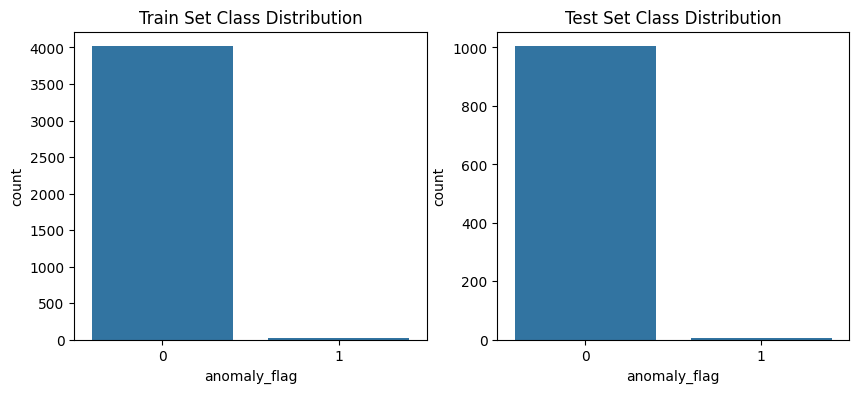

In [50]:
# Class distribution in train and test sets side by side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Train Set Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Set Class Distribution')
plt.show()


# 8. Preprocessing

Prepare data pipelines for numeric/categorical features:

- Numeric features imputed (median) and scaled (StandardScaler) for uniformity improving model convergence.
- Categorical features imputed (mode) and one-hot encoded for algorithm compatibility without numerical assumptions.
- Combined preprocessing via ColumnTransformer ensures structured handling within sklearn pipeline.

In [47]:
## Identify column types
numeric_features = X_train.select_dtypes(include=["int64", "float64", "number"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

print("Numeric columns:", list(numeric_features))
print("Categorical columns:", list(categorical_features))

Numeric columns: []
Categorical columns: ['layer_name', 'ctt_cms_contract_number', 'ctt_vin', 'ctt_asset_type_segment']


In [48]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # keep sparse default
])

In [49]:
## Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 9. Machine Learning Models

Train classifiers Logistic Regression and Random Forest:

- Logistic regression is robust, interpretable linear model suitable for classification.
- Random forest captures nonlinear feature interactions and generally achieves higher accuracy.
- Class imbalance addressed by class_weight='balanced' option, recalibrating model to minority anomaly instances.
- Train/test score printing assists performance inspection and potential overfitting detection.

## 9.1 Logistic Regression

In [57]:
log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

log_reg.fit(X_train, y_train)

print("Train accuracy:", log_reg.score(X_train, y_train))
print("Test accuracy:", log_reg.score(X_test, y_test))


Train accuracy: 0.9933234421364985
Test accuracy: 0.9930761622156281


In [58]:
### Addressing Class Imbalance
log_reg_2 = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced"))
]).fit(X_train, y_train)

log_reg_2.fit(X_train, y_train)

print("Train accuracy:", log_reg_2.score(X_train, y_train))
print("Test accuracy:", log_reg_2.score(X_test, y_test))

Train accuracy: 0.9967853610286844
Test accuracy: 0.9910979228486647


## 9.2 Random Forest

In [59]:
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)

print("Train accuracy:", rf.score(X_train, y_train))
print("Test accuracy:", rf.score(X_test, y_test))

Train accuracy: 0.9980217606330366
Test accuracy: 0.9910979228486647


In [60]:
### Addressing Class Imbalance
rf_2 = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"))
]).fit(X_train, y_train)

rf_2.fit(X_train, y_train)

print("Train accuracy:", rf_2.score(X_train, y_train))
print("Test accuracy:", rf_2.score(X_test, y_test))

Train accuracy: 0.9967853610286844
Test accuracy: 0.9910979228486647


# 10. Model Comparison

Evaluate models with multiple metrics:

- ROC AUC quantifies model discrimination capability.
- Precision, recall, F1 reflect correctness and completeness of anomaly identification.
- Average precision exemplifies performance under class imbalance (like PR AUC).
- Balanced accuracy balances sensitivity and specificity.
- Classification report and confusion matrix detail model outputs per class.

## 10.1 Metrics: ROC, AUC, Precision, Recall, Average Precision, F1-Score, Balanced Accuracy

In [61]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    metrics = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "pr_auc": average_precision_score(y_test, y_prob),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "balanced_acc": balanced_accuracy_score(y_test, y_pred),
    }
    print(metrics)
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    return metrics

In [62]:
print("=== Logistic Regression ===")
metrics_lr = evaluate(log_reg, X_test, y_test)

print("\n=== Random Forest ===")
metrics_rf = evaluate(rf, X_test, y_test)

summary = pd.DataFrame([
    {"model": "Logistic Regression", **metrics_lr},
    {"model": "Random Forest", **metrics_rf}
])
print(summary)

=== Logistic Regression ===
{'roc_auc': np.float64(0.5898548662492885), 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'pr_auc': np.float64(0.008683938732535238), 'f1': np.float64(0.0), 'balanced_acc': np.float64(0.5)}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1004
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1011
   macro avg       0.50      0.50      0.50      1011
weighted avg       0.99      0.99      0.99      1011

Confusion matrix:
 [[1004    0]
 [   7    0]]

=== Random Forest ===


c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

{'roc_auc': np.float64(0.49302788844621515), 'precision': np.float64(0.0), 'recall': np.float64(0.0), 'pr_auc': np.float64(0.006923837784371909), 'f1': np.float64(0.0), 'balanced_acc': np.float64(0.499003984063745)}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1004
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1011
   macro avg       0.50      0.50      0.50      1011
weighted avg       0.99      0.99      0.99      1011

Confusion matrix:
 [[1002    2]
 [   7    0]]
                 model   roc_auc  precision  recall    pr_auc   f1  \
0  Logistic Regression  0.589855        0.0     0.0  0.008684  0.0   
1        Random Forest  0.493028        0.0     0.0  0.006924  0.0   

   balanced_acc  
0      0.500000  
1      0.499004  


### Data Viz

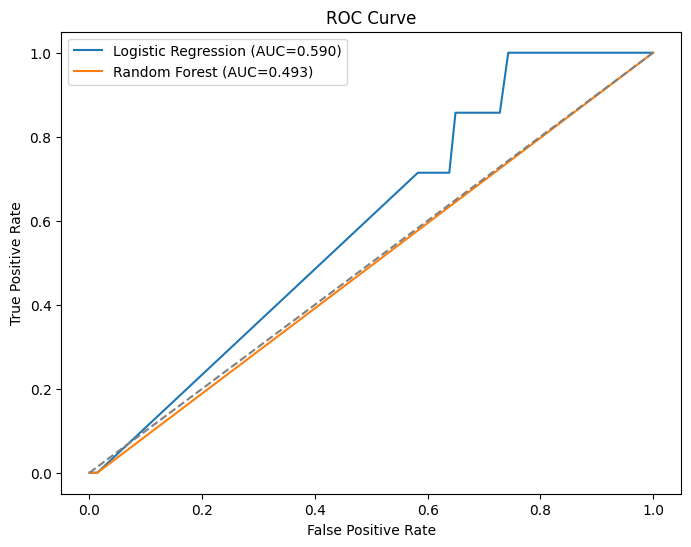

In [63]:
# ROC Curves for both models
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in [('Logistic Regression', log_reg), ('Random Forest', rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.3f})')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
